In [4]:
# BLS API Notebook: Fetch Labor Data
import requests
import json
import pandas as pd
import os
from datetime import datetime

# Ensure data folder exists
os.makedirs('data', exist_ok=True)

# BLS API key
API_KEY = 'fe5517b08aec4f7da63b911b04a549aa'

# Series IDs to pull
series_ids = {
    'Total Nonfarm Employment': 'CES0000000001',
    'Unemployment Rate (SA)': 'LNS14000000',
    'Civilian Labor Force': 'LNS11000000',
    'Average Hourly Earnings Private': 'CES0500000003',
    'CPI-U': 'CUUR0000SA0'
}

# Function to fetch BLS data for a list of series
def fetch_bls_data(series_ids, start_year=2010):
    #Use current year as end_year to remain dynamic
    end_year = datetime.now().year

    headers = {'Content-type': 'application/json'}
    data = json.dumps({
        "seriesid": list(series_ids.values()),
        "startyear": str(start_year),
        "endyear": str(end_year),
        "registrationKey": API_KEY
    })
    
    response = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(response.text)
    
    all_data = []
    
    for series in json_data['Results']['series']:
        series_name = [k for k,v in series_ids.items() if v == series['seriesID']][0]
        for item in series['data']:
            year = int(item['year'])
            period = item['period']
            if 'M01' <= period <= 'M12':  # Monthly data only
                month = int(period[1:])
                date = pd.Timestamp(year=year, month=month, day=1)
                value = float(item['value'].replace(',', ''))
                all_data.append({'Date': date, 'Series': series_name, 'Value': value})
    
    df = pd.DataFrame(all_data)
    df = df.sort_values(['Series', 'Date']).reset_index(drop=True)
    return df

# Fetch the data
df_labor = fetch_bls_data(series_ids, start_year=2010)

# Save to CSV
df_labor.to_csv('data/labor_data.csv', index=False)

# Preview
df_labor.head(10)

,Date,Series,Value
0,2010-01-01,Average Hourly Earnings Private,22.41
1,2010-02-01,Average Hourly Earnings Private,22.46
2,2010-03-01,Average Hourly Earnings Private,22.46
3,2010-04-01,Average Hourly Earnings Private,22.49
4,2010-05-01,Average Hourly Earnings Private,22.51
5,2010-06-01,Average Hourly Earnings Private,22.53
6,2010-07-01,Average Hourly Earnings Private,22.59
7,2010-08-01,Average Hourly Earnings Private,22.62
8,2010-09-01,Average Hourly Earnings Private,22.67
9,2010-10-01,Average Hourly Earnings Private,22.74


In [5]:
df_labor['Series'].unique()

array(['Average Hourly Earnings Private', 'CPI-U', 'Civilian Labor Force',
       'Total Nonfarm Employment', 'Unemployment Rate (SA)'], dtype=object)

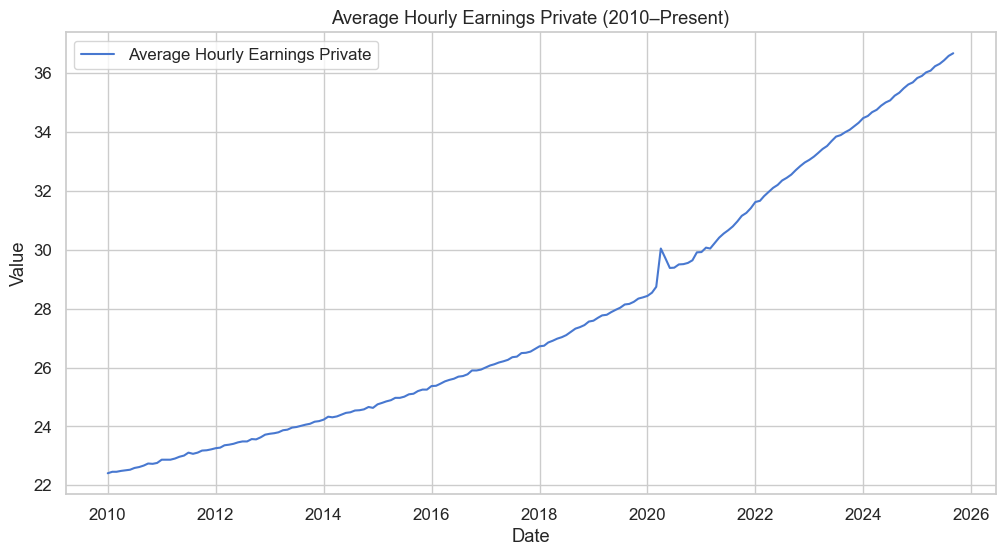

In [9]:
#Plot to explore Average Hourly Earnings Private
import matplotlib.pyplot as plt
import seaborn as sns

# Filter
df_subset = df_labor[df_labor['Series'] == 'Average Hourly Earnings Private']

# Set plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,6))

plt.plot(df_subset['Date'], df_subset['Value'], label='Average Hourly Earnings Private')

plt.title('Average Hourly Earnings Private (2010–Present)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

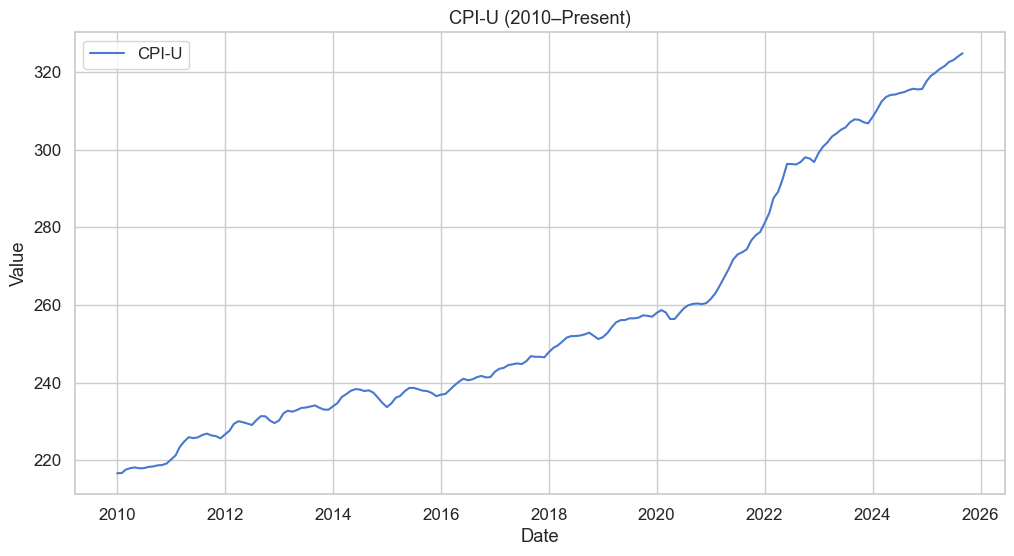

In [10]:
#Plot to explore CPI-U
import matplotlib.pyplot as plt
import seaborn as sns

# Filter
df_subset = df_labor[df_labor['Series'] == 'CPI-U']

# Set plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,6))

plt.plot(df_subset['Date'], df_subset['Value'], label='CPI-U')

plt.title('CPI-U (2010–Present)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

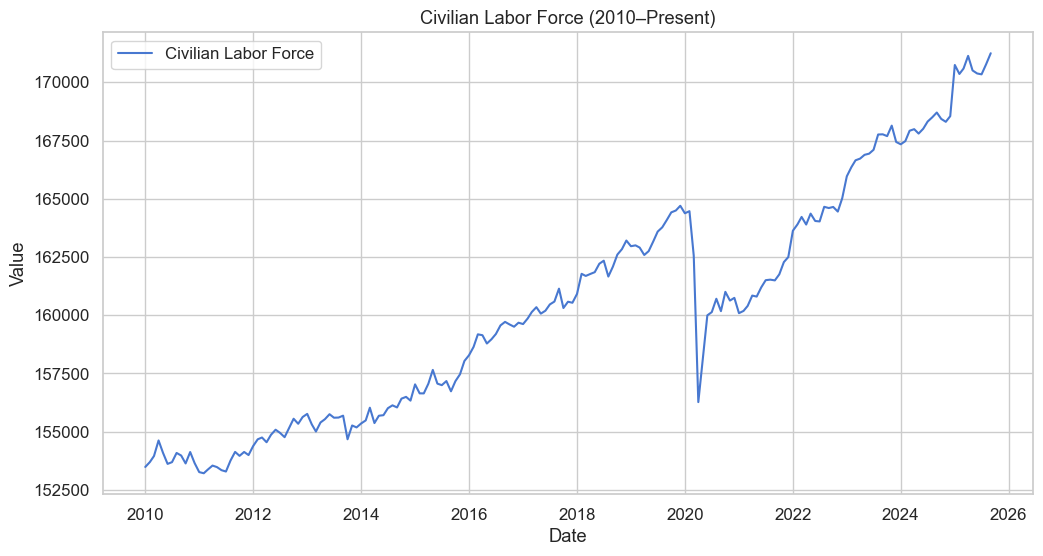

In [12]:
#Plot to explore Average Hourly Earnings Private
import matplotlib.pyplot as plt
import seaborn as sns

# Filter
df_subset = df_labor[df_labor['Series'] == 'Civilian Labor Force']

# Set plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,6))

plt.plot(df_subset['Date'], df_subset['Value'], label='Civilian Labor Force')

plt.title('Civilian Labor Force (2010–Present)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

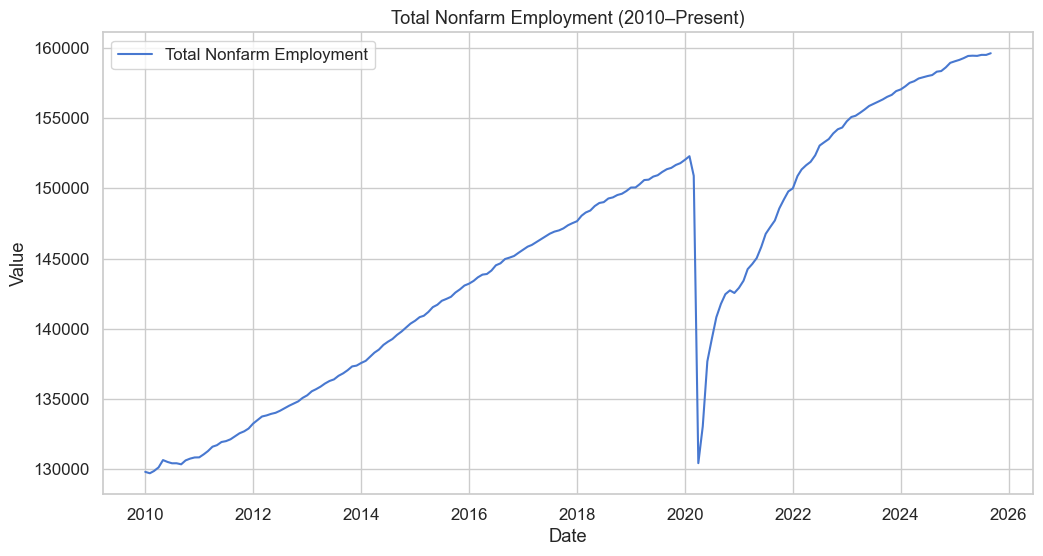

In [11]:
#Plot to explore Total Nonfarm Employment
import matplotlib.pyplot as plt
import seaborn as sns

# Filter
df_subset = df_labor[df_labor['Series'] == 'Total Nonfarm Employment']

# Set plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,6))

plt.plot(df_subset['Date'], df_subset['Value'], label='Total Nonfarm Employment')

plt.title('Total Nonfarm Employment (2010–Present)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

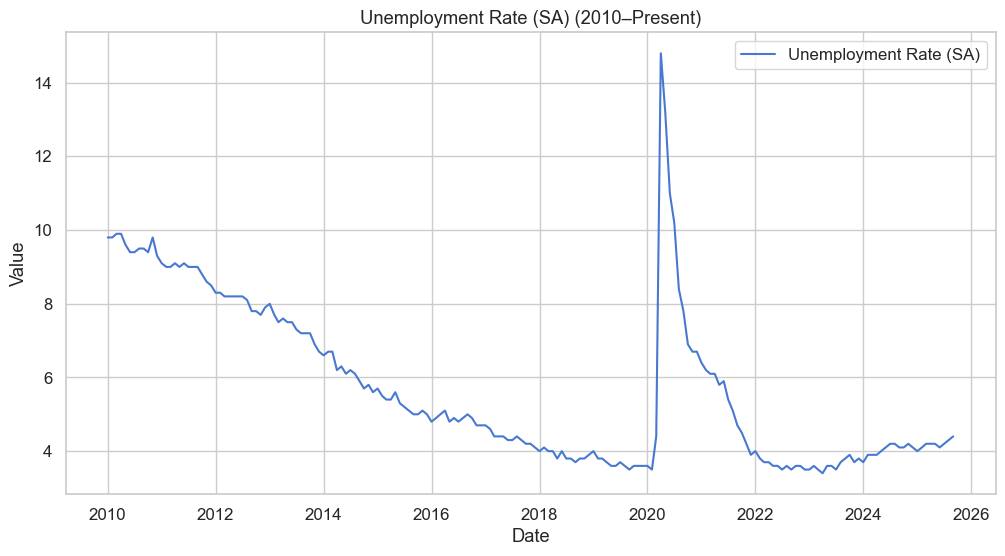

In [13]:
#Plot to explore Unemployment Rate (SA)
import matplotlib.pyplot as plt
import seaborn as sns

# Filter
df_subset = df_labor[df_labor['Series'] == 'Unemployment Rate (SA)']

# Set plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,6))

plt.plot(df_subset['Date'], df_subset['Value'], label='Unemployment Rate (SA)')

plt.title('Unemployment Rate (SA) (2010–Present)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [14]:
# Function to check for data completeness across all series
def check_missing_months(df):
    results = {}

    for series_name in df['Series'].unique():

        # Filter by this series
        df_subset = df[df['Series'] == series_name].set_index('Date')

        # Build full monthly index
        full_index = pd.date_range(
            start=df_subset.index.min(),
            end=df_subset.index.max(),
            freq='MS'
        )

        missing_months = full_index.difference(df_subset.index)

        if len(missing_months) == 0:
            results[series_name] = {
                "missing_count": 0,
                "missing_dates": []
            }
        else:
            results[series_name] = {
                "missing_count": len(missing_months),
                "missing_dates": list(missing_months)
            }

    return results
    
# Run it
missing_results = check_missing_months(df_labor)

# Print summary
for series, info in missing_results.items():
    if info["missing_count"] == 0:
        print(f"{series}: 0 missing months")
    else:
        print(f"{series}: {info['missing_count']} missing months")
        print("  → Dates:", info["missing_dates"])

Average Hourly Earnings Private: 0 missing months
CPI-U: 0 missing months
Civilian Labor Force: 0 missing months
Total Nonfarm Employment: 0 missing months
Unemployment Rate (SA): 0 missing months


In [15]:
# Basic summary stats per series
df_labor.groupby('Series')['Value'].describe()

,count,mean,std,min,25%,50%,75%,max
Series,,,,,,,,
Average Hourly Earnings Private,189.0,27.793810,4.244751,22.410,24.180,26.540,31.150,36.67
CPI-U,189.0,257.340688,31.276978,216.687,233.877,246.669,276.589,324.80
Civilian Labor Force,189.0,160353.052910,5024.295075,153214.000,155628.000,160184.000,164026.000,171248.00
Total Nonfarm Employment,189.0,144671.962963,8898.733201,129705.000,137041.000,145032.000,151365.000,159626.00
Unemployment Rate (SA),189.0,5.721693,2.209651,3.400,3.900,4.900,7.500,14.80


In [16]:
# Creates Master CSV
df_labor.to_csv('data/labor_data_master.csv', index=False)

In [17]:
# Load existing master if it exists
master_path = 'data/labor_data_master.csv'

if os.path.exists(master_path):
    df_master = pd.read_csv(master_path, parse_dates=['Date'])
    print("Master file loaded:", df_master.shape)
else:
    df_master = pd.DataFrame()
    print("No master file yet. Will create new.")

Master file loaded: (945, 3)


In [18]:
# Merge and append new records
df_combined = pd.concat([df_master, df_labor]).drop_duplicates()

# Sort
df_combined = df_combined.sort_values(['Series', 'Date']).reset_index(drop=True)

# Save
df_combined.to_csv(master_path, index=False)

print("Updated master:", df_combined.shape)

Updated master: (945, 3)
